In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy.stats as st 
from tqdm import tqdm 
import os
## Change directory to your working directory
os.chdir('D:\Shashi Katteri\Desktop\data sets to work on\Amazon Employee Access\Dataset_10')

In [2]:
df=pd.read_csv('Amazon_employee_access.csv')
df.head()

,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE,target
0,39353,85475,117961,118300,123472,117905,117906,290919,117908,1
1,17183,1540,117961,118343,123125,118536,118536,308574,118539,1
2,36724,14457,118219,118220,117884,117879,267952,19721,117880,1
3,36135,5396,117961,118343,119993,118321,240983,290919,118322,1
4,42680,5905,117929,117930,119569,119323,123932,19793,119325,1


In [3]:
df1=df.astype(str)
df1['target']=df1['target'].astype(int)

In [4]:
#df1['ROLE_ROLLUP_12']=df1['ROLE_ROLLUP_1']+df1['ROLE_ROLLUP_2']
df1=df1.drop(['ROLE_TITLE','ROLE_FAMILY'],axis=1)


In [5]:
df1['target']=df1['target'].map({1:0,0:1})

In [6]:
df1['ROLLUP_12']=df1['ROLE_ROLLUP_1']+df1['ROLE_ROLLUP_2']
df1=df1.drop(['ROLE_ROLLUP_1','ROLE_ROLLUP_2'],axis=1)

In [7]:
df1.head()

,RESOURCE,MGR_ID,ROLE_DEPTNAME,ROLE_FAMILY_DESC,ROLE_CODE,target,ROLLUP_12
0,39353,85475,123472,117906,117908,0,117961118300
1,17183,1540,123125,118536,118539,0,117961118343
2,36724,14457,117884,267952,117880,0,118219118220
3,36135,5396,119993,240983,118322,0,117961118343
4,42680,5905,119569,123932,119325,0,117929117930


# Combinations with brute force 


In [8]:
from itertools import combinations

cols=list(df1.columns)
cols.remove('target')
d=df1.copy()

for j in combinations(cols,2):
    d[j[0]+'_'+j[1]]=df1[j[0]]+df1[j[1]]
    
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 22 columns):
RESOURCE                          32769 non-null object
MGR_ID                            32769 non-null object
ROLE_DEPTNAME                     32769 non-null object
ROLE_FAMILY_DESC                  32769 non-null object
ROLE_CODE                         32769 non-null object
target                            32769 non-null int64
ROLLUP_12                         32769 non-null object
RESOURCE_MGR_ID                   32769 non-null object
RESOURCE_ROLE_DEPTNAME            32769 non-null object
RESOURCE_ROLE_FAMILY_DESC         32769 non-null object
RESOURCE_ROLE_CODE                32769 non-null object
RESOURCE_ROLLUP_12                32769 non-null object
MGR_ID_ROLE_DEPTNAME              32769 non-null object
MGR_ID_ROLE_FAMILY_DESC           32769 non-null object
MGR_ID_ROLE_CODE                  32769 non-null object
MGR_ID_ROLLUP_12                  32769 non-null obj

In [9]:
from lightgbm import LGBMClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split,StratifiedKFold,KFold
from catboost import CatBoostClassifier

In [10]:
def aucroc(mod,x,y):
    pred=mod.predict(x)
    prob=mod.predict_proba(x)[:,1]
    auc=roc_auc_score(y,prob)
    
    return auc

In [11]:
import warnings
warnings.filterwarnings('ignore')
def kfold_AS_target(train,test,columns,target,weight,folds=10):
    
    columns=list(columns)
    kf=KFold()
    t=train
    v=test
    gm=t[target].mean()
    for col in columns:
        
        for i,j in kf.split(t):
            gb=t.loc[t.index[i]].groupby(col)[target].agg(['count','mean'])
            count=gb['count']
            mean=gb['mean']
            gb['smooth']=(count*mean + weight*gm)/(count+weight)
            t.loc[t.index[j],col+'_enc']=t.loc[t.index[j],col].map(gb['smooth'])
            
        t[col+'_enc']=t[col+'_enc'].fillna(gm)
        
        gb=t.groupby(col)[target].agg(['count','mean'])
        count=gb['count']
        mean=gb['mean']
        gb['smooth']=(count*mean + weight*gm)/(count+weight)
        
        v[col+'_enc']=v[col].map(gb['smooth'])
        v[col+'_enc']=v[col+'_enc'].fillna(gm)
        
    t=t.drop(columns,axis=1)
    v=v.drop(columns,axis=1)

    return t,v
        

In [12]:
rem=['MGR_ID_ROLE_DEPTNAME', 'MGR_ID', 'ROLE_DEPTNAME_ROLLUP_12', 'MGR_ID_ROLLUP_12', 'ROLLUP_12', 'ROLE_CODE_ROLLUP_12',
     'RESOURCE_ROLE_FAMILY_DESC']
d1=d.drop(rem,axis=1)

In [13]:
train,test=train_test_split(d1,test_size=0.3,random_state=64)

In [14]:
cols=list(d1.columns)
cols.remove('target')
target='target'
t,v=kfold_AS_target(train,test,cols,target,100)

xtr=t.drop(target,axis=1)
xts=v.drop(target,axis=1)
ytr=t[target]
yts=v[target] 


train auc score=  0.9045228303053183
test auc score=  0.9051713788342637


Text(0, 0.5, 'TPR')

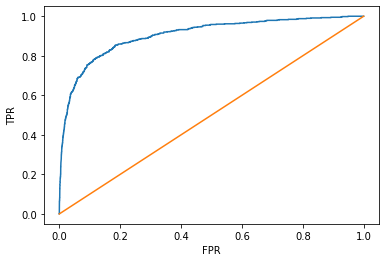

In [15]:
params={'learning_rate':0.01,'depth':6,'verbose':False,'eval_metric':'AUC',
        'loss_function':'CrossEntropy'}

cb=CatBoostClassifier(**params)
mod=cb.fit(xtr,ytr)

prob1=mod.predict_proba(xtr)[:,1]
prob2=mod.predict_proba(xts)[:,1]
fpr,tpr,thresh=roc_curve(yts,prob2)
roc=pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':thresh})
auc_tr=roc_auc_score(ytr,prob1)
auc_ts=roc_auc_score(yts,prob2)

print('train auc score= ',auc_tr)
print('test auc score= ',auc_ts)
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
###134 89.7
###0   89.6

In [16]:
roc.head()

,fpr,tpr,threshold
0,0.000000,0.000000,1.920252
1,0.000108,0.000000,0.920252
2,0.000108,0.022569,0.840828
3,0.000108,0.029514,0.834602
4,0.000108,0.038194,0.826118


In [17]:
#Youden’s J statistic.
roc['J index']=tpr-fpr
roc['Gmean']=(tpr*(1-fpr))**2
roc['J rank']=roc['J index'].rank(method='min',ascending=False)
roc['Gmean rank']=roc['Gmean'].rank(method='min',ascending=False)
roc.head()

,fpr,tpr,threshold,J index,Gmean,J rank,Gmean rank
0,0.000000,0.000000,1.920252,0.000000,0.000000,1256.0,1256.0
1,0.000108,0.000000,0.920252,-0.000108,0.000000,1258.0,1256.0
2,0.000108,0.022569,0.840828,0.022461,0.000509,1255.0,1255.0
3,0.000108,0.029514,0.834602,0.029406,0.000871,1254.0,1254.0
4,0.000108,0.038194,0.826118,0.038086,0.001459,1252.0,1252.0


In [33]:
top=roc[roc['J rank']<11]
top

,fpr,tpr,threshold,J index,Gmean,J rank,Gmean rank
523,0.112372,0.781250,0.059009,0.668878,0.480886,2.0,13.0
524,0.113668,0.781250,0.058168,0.667582,0.479482,10.0,39.0
535,0.118855,0.786458,0.055881,0.667604,0.480227,9.0,19.0
539,0.119611,0.788194,0.055519,0.668583,0.481522,4.0,10.0
541,0.122312,0.789931,0.053971,0.667618,0.480682,8.0,14.0
547,0.125014,0.793403,0.052733,0.668389,0.481937,5.0,7.0
662,0.183576,0.852431,0.037255,0.668854,0.484339,3.0,2.0
663,0.184333,0.852431,0.037243,0.668098,0.483442,6.0,3.0
664,0.184549,0.852431,0.037205,0.667882,0.483185,7.0,4.0
665,0.184549,0.854167,0.037151,0.669618,0.485156,1.0,1.0


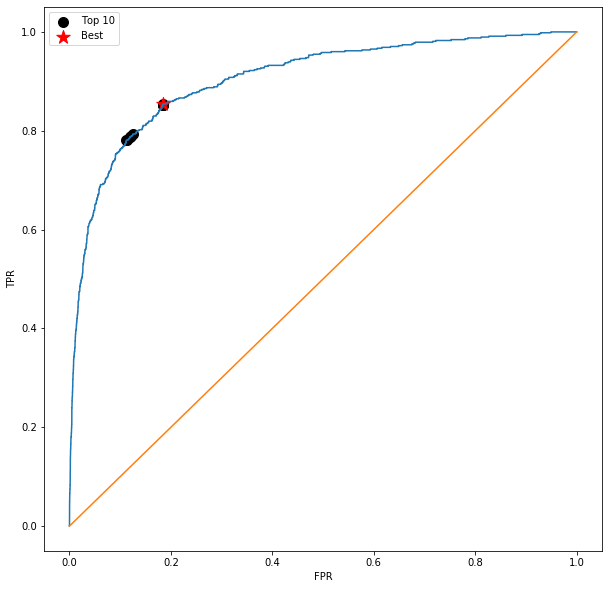

In [19]:
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
#plt.vlines(x=0,ymin=0,ymax=1)
#plt.hlines(y=1,xmin=0,xmax=1)
plt.scatter(x=top['fpr'],y=top['tpr'],marker='o',color='black',label='Top 10',s=100)
plt.scatter(x=0.184549,y=0.854167,marker='*',color='r',label='Best',s=200)
plt.legend()

high=0
for i in tqdm(range(100)):    
    train,test=train_test_split(d1,test_size=0.3,random_state=i)

    cols=list(d1.columns)
    cols.remove('target')
    target='target'
    t,v=kfold_AS_target(train,test,cols,target,100)

    xtr=t.drop(target,axis=1)
    xts=v.drop(target,axis=1)
    ytr=t[target]
    yts=v[target] 

    params={'learning_rate':0.01,'depth':6,'verbose':False,'eval_metric':'AUC',
            'loss_function':'CrossEntropy'}

    cb=CatBoostClassifier(**params)
    mod=cb.fit(xtr,ytr)
    prob2=mod.predict_proba(xts)[:,1]
    auc_ts=roc_auc_score(yts,prob2)
    if auc_ts>high:
        high=auc_ts
        rs=i

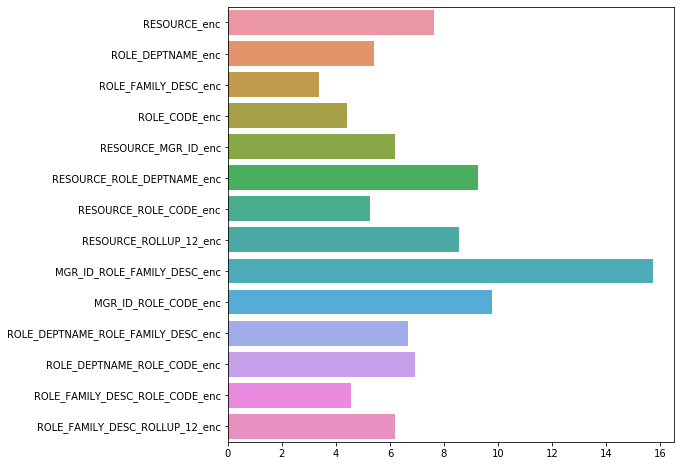

In [40]:
plt.figure(figsize=(8,8))
sns.barplot(y=xtr.columns,x=mod.feature_importances_)

#plt.xticks(rotation=90)

In [26]:
result=pd.DataFrame({'Prob':prob2})
result.head()

,Prob
0,0.027567
1,0.003622
2,0.025281
3,0.007416
4,0.007112


In [34]:
result['t1']=result['Prob'].apply(lambda x:1 if x>=0.037151 else 0)
result['t2']=result['Prob'].apply(lambda x:1 if x>=0.059009 else 0)
result['t3']=result['Prob'].apply(lambda x:1 if x>=0.052733 else 0)

In [35]:
def score(pred,ytr):
    accuracy=accuracy_score(ytr,pred)
    print('\n',classification_report(ytr,pred))
    print('\n Confusion matrix:\n',confusion_matrix(ytr,pred))


In [36]:
score(result['t1'],yts)


               precision    recall  f1-score   support

           0       0.99      0.82      0.89      9255
           1       0.22      0.85      0.35       576

    accuracy                           0.82      9831
   macro avg       0.61      0.83      0.62      9831
weighted avg       0.94      0.82      0.86      9831


 Confusion matrix:
 [[7547 1708]
 [  84  492]]


In [37]:
score(result['t2'],yts)


               precision    recall  f1-score   support

           0       0.98      0.89      0.93      9255
           1       0.30      0.78      0.43       576

    accuracy                           0.88      9831
   macro avg       0.64      0.83      0.68      9831
weighted avg       0.94      0.88      0.90      9831


 Confusion matrix:
 [[8215 1040]
 [ 127  449]]


In [38]:
score(result['t3'],yts)


               precision    recall  f1-score   support

           0       0.99      0.87      0.93      9255
           1       0.28      0.79      0.42       576

    accuracy                           0.87      9831
   macro avg       0.63      0.83      0.67      9831
weighted avg       0.94      0.87      0.90      9831


 Confusion matrix:
 [[8098 1157]
 [ 119  457]]
